In [11]:
#import cac thu vieb can thiet
from tensorflow import keras
from tensorflow.keras import layers
import os
import numpy as np
import cv2
from glob import glob
from sklearn import model_selection
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard
from tensorflow.keras.metrics import Precision, Recall, MeanIoU
import matplotlib.pyplot as plt
from tensorflow.keras.utils import CustomObjectScope
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam, Nadam, SGD

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
cd /content/drive/'My Drive'/xla

/content/drive/My Drive/xla


In [14]:
#parameter
size_unet=256
#Lua chon cac sieu tham so Hyperparameters
batch=8
lr = 1e-4
epochs = 40

In [15]:
#Ham tra ve tap train, tap valid va tap test
def load_data():
    #Tach tap du lieu thanh 80% cho train, 10% cho val, 10% cho test
    split=0.1;
    images = sorted(glob( "images/*"))
    masks = sorted(glob("masks/*"))
    #glob giup hoan thien cac duong dan

    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)
    #random_state tham so cho viec tao so ngau nhien va 42 la so thuong duoc dung
    train_x, valid_x = model_selection.train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = model_selection.train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = model_selection.train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = model_selection.train_test_split(train_y, test_size=test_size, random_state=42)
    #print("Tong so anh {}".format(total_size))
    #print("So anh trainning {}".format(len(train_y)))
    #print("So anh dung de danh gia {}".format(len(valid_x)))
    #print("So anh dung de test {}".format(len(test_x)))
    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [16]:
#Ap dung voi tap val va tap test
#Doc hinh anh sau do chuan hoa
def read_image(path):
    path=path.decode()
    x = cv2.imread(path,cv2.IMREAD_COLOR)
    #Voi dau vao la mot hinh anh mau
    x = cv2.resize(x, (size_unet,size_unet))
    x = x/255.0
    return x

def read_mask(path):
    path=path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (size_unet, size_unet))
    x = x/255.0
    #Them cho du 3 chieu
    x = np.expand_dims ( x, axis = -1)
    return x
#Ham chuyen cac anh ve dang tensorflow
def tf_convert(x, y):
    def _convert(x, y):
      x=read_image(x)
      y=read_mask(y)
      return x,y
    #Chuyen sang dang tensor de dua vao mo hinh
    x, y = tf.numpy_function(_convert, [x, y], [tf.float64, tf.float64])
    #Xac nhan lai hinh dang
    x.set_shape([size_unet, size_unet, 3])
    y.set_shape([size_unet, size_unet, 1])
    return x, y
#Chuan bi de du lieu hoat dong hieu qua voi GPU
#Neu khong co viec chuan bi nay GPU se phai doi CPU load xong du lieu gay ton kem thoi gian
#Cach giai quyet la xu ly song song (pipeline) khi GPU xu ly thi CPU tien hanh chuan bi 
#Dieu nay thuc hien bang cach su dung Tensorflow Dataset API

def tf_dataset(x, y, batch=8):
    #Ham from_tensor_slices() để tạo 1 Dataset objects
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    #Sua lai dung dinh dang ta can thong qua ham tf_convert
    dataset = dataset.map(tf_convert)
    #Chia du lieu theo batch da dinh truoc
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    #Train batch qua nhieu epoch
    dataset = dataset.repeat()
    return dataset


In [17]:
#Tang cuong du lieu va chuan hoa hinh anh voi cac lop cua Keras
#cac seed tao so ngau nhien phai giong nhau de phu hop giua anh goc va mat na
def Augment(seed=37):
    img = tf.keras.Input(shape=(None,None,3))
    msk = tf.keras.Input(shape=(None,None,1))

    #Lat hinh anh ca tren va duoi
    i = tf.keras.layers.RandomFlip("horizontal",seed=seed)(img)
    m = tf.keras.layers.RandomFlip("horizontal",seed=seed)(msk)
    #Dich vi tri hinh anh mot cach ngau nhien
    i = tf.keras.layers.RandomTranslation((-0.15, 0.15),(-0.15, 0.15),seed=seed)(i)
    m = tf.keras.layers.RandomTranslation((-0.15, 0.15),(-0.15, 0.15),seed=seed)(m)
    #Xoay hinh anh
    i = tf.keras.layers.RandomRotation((-0.15, 0.15),seed=seed)(i)
    m = tf.keras.layers.RandomRotation((-0.15, 0.15),seed=seed)(m)
    #Zoom hinh anh
    i = tf.keras.layers.RandomZoom((-0.1, 0.05),(-0.1, 0.05),seed=seed)(i)
    m = tf.keras.layers.RandomZoom((-0.1, 0.05),(-0.1, 0.05),seed=seed)(m)
    #Chuan hoa lai hinh anh
    i = tf.keras.layers.Rescaling(scale=1./255)(i)
    m = tf.keras.layers.Rescaling(scale=1./255)(m)
    
    return tf.keras.Model(inputs=(img,msk), outputs=(i,m))
Augment = Augment()

In [18]:
#Ap dung voi tap train
#Doc hinh anh sau do chuan hoa
def read_image_train(path):
    path=path.decode()
    x = cv2.imread(path,cv2.IMREAD_COLOR)
    #Voi dau vao la mot hinh anh mau
    x = cv2.resize(x, (size_unet,size_unet))
    x = x/1.0
    return x

def read_mask_train(path):
    path=path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (size_unet, size_unet))
    x = x/1.0
    #Them cho du 3 chieu
    x = np.expand_dims ( x, axis = -1)
    return x
#Ham chuyen cac anh ve dang tensorflow
def tf_convert_train(x, y):
    def _convert_train(x, y):
      x=read_image_train(x)
      y=read_mask_train(y)
      return x,y
    #Chuyen sang dang tensor de dua vao mo hinh
    x, y = tf.numpy_function(_convert_train, [x, y], [tf.float64, tf.float64])
    #Xac nhan lai hinh dang
    x.set_shape([size_unet, size_unet, 3])
    y.set_shape([size_unet, size_unet, 1])
    return x, y
#Chuan bi de du lieu hoat dong hieu qua voi GPU
#Neu khong co viec chuan bi nay GPU se phai doi CPU load xong du lieu gay ton kem thoi gian
#Cach giai quyet la xu ly song song (pipeline) khi GPU xu ly thi CPU tien hanh chuan bi 
#Dieu nay thuc hien bang cach su dung Tensorflow Dataset API
def tf_dataset_train(x, y, batch=8):
    #Ham from_tensor_slices() để tạo 1 Dataset objects
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    #Sua lai dung dinh dang ta can thong qua ham tf_convert_train
    dataset = dataset.map(tf_convert_train)
    #Chia du lieu theo batch da dinh truoc
    dataset = dataset.batch(batch).map(lambda x,y: Augment((x,y)))
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    #Train batch qua nhieu epoch
    dataset = dataset.repeat()
    return dataset


In [19]:
#Ham danh gia dice coef
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [20]:
(train_x,train_y), (valid_x,valid_y),(test_x,test_y)=load_data()

train_dataset = tf_dataset_train(train_x, train_y, batch=batch)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch)
test_dataset = tf_dataset(test_x, test_y, batch=batch)

In [21]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model 

def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def stem_block(x, n_filter, strides):
    x_init = x

    ## Conv 1
    x = Conv2D(n_filter, (3, 3), padding="same", strides=strides)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same")(x)

    ## Shortcut
    s  = Conv2D(n_filter, (1, 1), padding="same", strides=strides)(x_init)
    s = BatchNormalization()(s)

    ## Add
    x = Add()([x, s])
    x = squeeze_excite_block(x)
    return x


def resnet_block(x, n_filter, strides=1):
    x_init = x

    ## Conv 1
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same", strides=strides)(x)
    ## Conv 2
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same", strides=1)(x)

    ## Shortcut
    s  = Conv2D(n_filter, (1, 1), padding="same", strides=strides)(x_init)
    s = BatchNormalization()(s)

    ## Add
    x = Add()([x, s])
    x = squeeze_excite_block(x)
    return x

def aspp_block(x, num_filters, rate_scale=1):
    x1 = Conv2D(num_filters, (3, 3), dilation_rate=(6 * rate_scale, 6 * rate_scale), padding="same")(x)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
    x4 = BatchNormalization()(x4)

    y = Add()([x1, x2, x3, x4])
    y = Conv2D(num_filters, (1, 1), padding="same")(y)
    return y

def attetion_block(g, x):
    """
        g: Output of Parallel Encoder block
        x: Output of Previous Decoder block
    """

    filters = x.shape[-1]

    g_conv = BatchNormalization()(g)
    g_conv = Activation("relu")(g_conv)
    g_conv = Conv2D(filters, (3, 3), padding="same")(g_conv)

    g_pool = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(g_conv)

    x_conv = BatchNormalization()(x)
    x_conv = Activation("relu")(x_conv)
    x_conv = Conv2D(filters, (3, 3), padding="same")(x_conv)

    gc_sum = Add()([g_pool, x_conv])

    gc_conv = BatchNormalization()(gc_sum)
    gc_conv = Activation("relu")(gc_conv)
    gc_conv = Conv2D(filters, (3, 3), padding="same")(gc_conv)

    gc_mul = Multiply()([gc_conv, x])
    return gc_mul

class ResUnetPlusPlus:
    def __init__(self, input_size=256):
        self.input_size = input_size

    def build_model(self):
        n_filters = [64, 128, 256, 512, 1024]
        inputs = Input((self.input_size, self.input_size, 3))

        c0 = inputs
        c1 = stem_block(c0, n_filters[0], strides=1)

        ## Encoder
        c2 = resnet_block(c1, n_filters[1], strides=2)
        c3 = resnet_block(c2, n_filters[2], strides=2)
        c4 = resnet_block(c3, n_filters[3], strides=2)

        ## Bridge
        b1 = aspp_block(c4, n_filters[4])

        ## Decoder
        d1 = attetion_block(c3, b1)
        d1 = UpSampling2D((2, 2))(d1)
        d1 = Concatenate()([d1, c3])
        d1 = resnet_block(d1, n_filters[3])

        d2 = attetion_block(c2, d1)
        d2 = UpSampling2D((2, 2))(d2)
        d2 = Concatenate()([d2, c2])
        d2 = resnet_block(d2, n_filters[2])

        d3 = attetion_block(c1, d2)
        d3 = UpSampling2D((2, 2))(d3)
        d3 = Concatenate()([d3, c1])
        d3 = resnet_block(d3, n_filters[1])

        ## output
        outputs = aspp_block(d3, n_filters[0])
        outputs = Conv2D(1, (1, 1), padding="same")(outputs)
        outputs = Activation("sigmoid")(outputs)

        ## Model
        model = Model(inputs, outputs)
        return model

In [22]:
arch = ResUnetPlusPlus(input_size=size_unet)
model = arch.build_model()
opt = tf.keras.optimizers.Nadam(lr)
metrics = [Recall(), Precision(), dice_coef, MeanIoU(num_classes=2)]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [23]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                           

In [24]:
#Cac tham so ta se quan sat
callbacks = [
          #Luu bo trong so weight    
          ModelCheckpoint("filesr/model.h5"),
          #Theo doi loss function va giam LR
          #factor gia tri learning rate se giam 
          #patience: sau so chu ky ma LR se giam
          ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3),
          #Truyen lai ket qua vao CSV
          CSVLogger("filesr/data.csv"),
          TensorBoard(),
          #Theo doi loss function
          #patience: sau so chu ky neu khong cai thien thi dung
          #restore_best_weights: lua chon khoi phuc tu epoch co ket qua tot nhat
          EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
     ]

In [ ]:
train_steps = len(train_x)//batch
valid_steps = len(valid_x)//batch


if len(train_x) % batch != 0:
        train_steps += 1
if len(valid_x) % batch != 0:
        valid_steps += 1

history=model.fit(train_dataset,
validation_data=valid_dataset,
epochs=epochs,
steps_per_epoch=train_steps,
validation_steps=valid_steps,
callbacks=callbacks,
)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/40
100/100 [==============================] - 320s 3s/step - loss: 0.4854 - recall: 0.5778 - precision: 0.4913 - dice_coef: 0.5146 - mean_io_u: 0.5818 - val_loss: 0.6014 - val_recall: 0.3503 - val_precision: 0.4741 - val_dice_coef: 0.3993 - val_mean_io_u: 0.5083 - lr: 1.0000e-04
Epoch 2/40
100/100 [==============================] - 320s 3s/step - loss: 0.4666 - recall: 0.5849 - precision: 0.5140 - dice_coef: 0.5334 - mean_io_u: 0.5922 - val_loss: 0.7310 - val_recall: 0.1578 - val_precision: 0.6689 - val_dice_coef: 0.2648 - val_mean_io_u: 0.4542 - lr: 1.0000e-04
Epoch 3/40
100/100 [==============================] - 311s 3s/step - loss: 0.4528 - recall: 0.5822 - precision: 0.5370 - dice_coef: 0.5472 - mean_io_u: 0.6004 - val_loss: 0.6422 - val_recall: 0.2613 - val_precision: 0.5235 - val_dice_coef: 0.3496 - val_mean_io_u: 0.4985 - lr: 1.0000e-04
Epoch 4/40
100/100 [==============================] - 320s 3s/step - loss: 0.4435 - recall: 0.5842 - precision: 0.5504 - dice_coef: 0.55

dict_keys(['loss', 'recall', 'precision', 'dice_coef', 'mean_io_u', 'val_loss', 'val_recall', 'val_precision', 'val_dice_coef', 'val_mean_io_u', 'lr'])


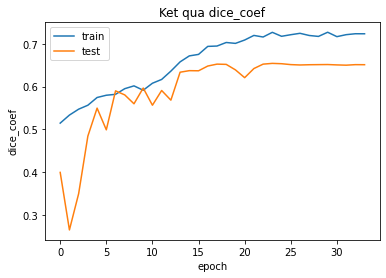

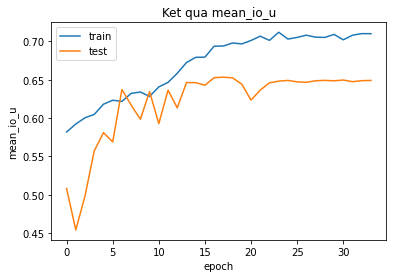

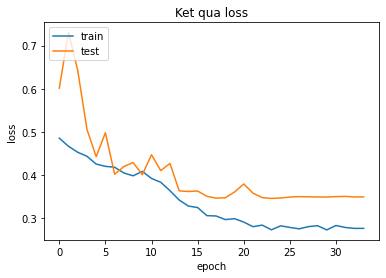

In [ ]:
print(history.history.keys())
# summarize history for dice_coef
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Ket qua dice_coef')
plt.ylabel('dice_coef')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for accuracy
plt.plot(history.history['mean_io_u'])
plt.plot(history.history['val_mean_io_u'])
plt.title('Ket qua mean_io_u')
plt.ylabel('mean_io_u')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Ket qua loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
test_steps = (len(test_x)//batch)
if len(test_x) % batch != 0:
  test_steps += 1
with CustomObjectScope({'dice_loss': dice_loss, 'dice_coef': dice_coef}):
  model = tf.keras.models.load_model("filesr/model.h5")
model.evaluate(test_dataset, steps=test_steps)

13/13 [==============================] - 28s 2s/step - loss: 0.3347 - recall: 0.5971 - precision: 0.7410 - dice_coef: 0.6664 - mean_io_u: 0.6549


[0.33466270565986633,
 0.5971142053604126,
 0.7409806251525879,
 0.6664219498634338,
 0.6549040079116821]

In [ ]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (256, 256))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    x = np.expand_dims(x, axis=-1)
    return x

def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

In [ ]:
for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):
        x = read_image(x)
        y = read_mask(y)
        y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
        h, w, _ = x.shape
        white_line = np.ones((h, 10, 3)) * 255.0

        all_images = [
            x * 255.0, white_line,
            mask_parse(y), white_line,
            mask_parse(y_pred) * 255.0
        ]
        image = np.concatenate(all_images, axis=1)
        cv2.imwrite(f"resultsr/{i}.png", image)

100%|██████████| 100/100 [00:25<00:00,  3.87it/s]
